# SCIPYで音楽制作！？

１。適当に数式を作ってみる。

\begin{eqnarray}
y=\sum^{\lceil x \rceil}_{n=0}sin(x+n)^a
\end{eqnarray}

どんなグラフが出るかな〜〜〜

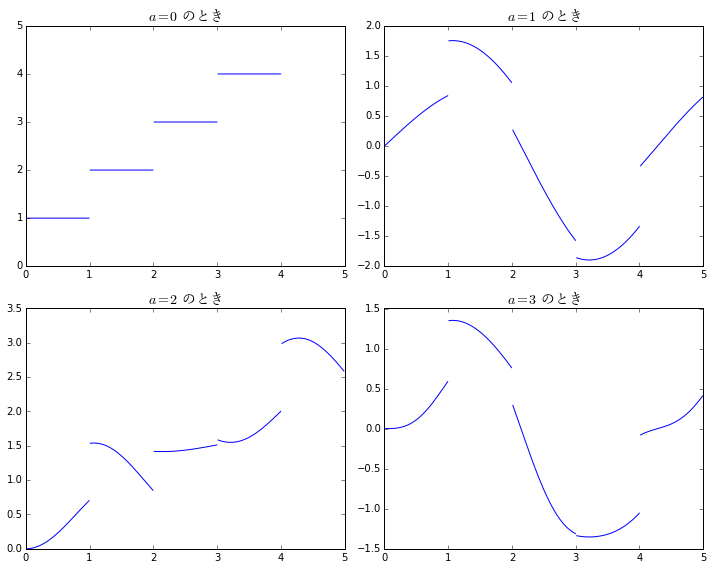

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fp = FontProperties(fname=r'/Library/Fonts/YuMincho.ttc', size=14)

resolution = lambda x: x*100;
resolution_linspace = lambda x,y: np.linspace(x, y, resolution(y));

def original_graph(x, a):
    answer = 0
    for n in range(0, np.ceil(x).astype(int)):
        answer += np.power(np.sin(x+n), a)
    return answer

def clean_graph(x,y): # floor(x)が変化した時のyをNoneにする
    before = np.floor(x[0]).astype(int)
    for i in range(0, len(y)):
        if before < np.floor(x[i]).astype(int):
            y[i] = None
            y[i] = None
        before = np.floor(x[i]).astype(int)

v_original_graph = np.vectorize(original_graph, otypes=[np.float])

plt.figure(figsize=(10,8))

for a in range(0, 4):
    plt.subplot(2, 2, a+1)
    plt.title('$a=' + str(a) + '$ のとき', fontproperties=fp)
    x = resolution_linspace(0, 5);
    y = v_original_graph(x, a)
    clean_graph(x, y)
    plt.plot(x, y)

plt.tight_layout()
plt.show()

まあ、xをceilしている以上当たり前だけど、1の倍数ごとにグラフの形が全然違ってくる。

つまり、0から1までのぐらふと、1から2までのグラフは全くの別物と言っていい。

じゃあ、次は積分してみよう！

\begin{eqnarray}
y=\int_{\lfloor x \rfloor}^{x}\sum^{\lceil x \rceil}_{n=0}sin(x+n)^a
\end{eqnarray}

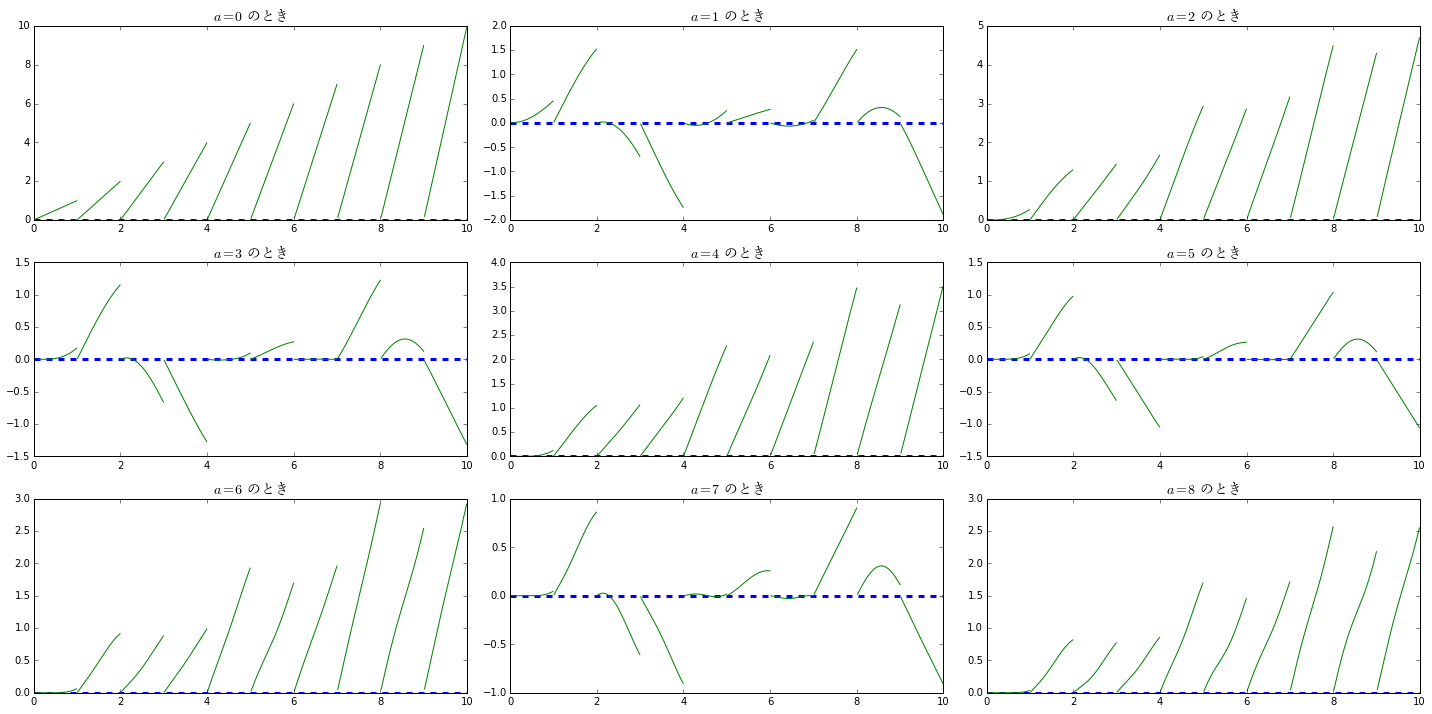

In [2]:
from scipy import integrate

def integrated(x,a):
    return integrate.quad(original_graph, np.floor(x), x, a)

v_integrated = np.vectorize(integrated, otypes=[np.float,np.float])

plt.figure(figsize=(20,10))

for a in range(0, 9):
    plt.subplot(3, 3, a+1)
    plt.title('$a=' + str(a) + '$ のとき', fontproperties=fp)
    
    x = resolution_linspace(0, 10);
    y = v_integrated(x, a)[0]
    
    clean_graph(x, y)
    
    plt.plot(resolution_linspace(0, 10), np.zeros(resolution(10)), '--', linewidth=3.0)
    
    plt.plot(x, y)

plt.tight_layout()
plt.show()

おお。いい感じ。

ではでは。やっとの事で本題です。ここからちょーかっこいいげんだいおんがくを作っていくよ!

(イェイ)!

とりあえず$y=0.0$のときの値を130.815Hz.として、そこから上がったり下がったりするごとにホワンホワンなる感じで作って行きまっか。

In [8]:
from scipy.io.wavfile import write
from scipy import interpolate

sr = 44100 # サンプリングレート
zero = 130.815 # オフセット
power = zero # 変化の倍率。周波数=zero+(y*power)となる。

# 周波数用のv_integrated(44100回も計算していられないので作った)。必ずn回計算をする。
"""
def f_integrated(x, a, n):
    avg = [s.mean() for s in np.hsplit(x,n)]
    out = np.empty(0, dtype=np.float)
    for i in avg:
        tmp = np.empty(np.floor(len(x)/n).astype(int), dtype=np.float)
        tmp.fill(integrated(i,a)[0])
        out = np.append(out, tmp)
    return out
"""

# 周波数用のv_integrated(44100回も計算していられないので作った)。必ずn回計算をする。線形補間先生ぱねえ。
def f_integrated(x, y, z, n, a, kind="linear"):
    t = np.linspace(x, y, n)
    t2 = np.linspace(x, y, z)
    
    v = v_integrated(t, a)
    f = interpolate.interp1d(t, v, kind)
    v2 = f(t2)
    
    clean_graph(t2,v2)
    return v2

# 変化の量から正弦波をつくりだす
# 元となるデータ、サンプリングレート、周波数のオフセット、周波数の変化の倍率、の順。　
def towave(x, sr, z=0, p=1):
    return np.sin(2*np.pi*(z+x*p)*np.linspace(0, len(x)/sr, len(x)));

length = 10 # 曲の長さ
N = 1000*length # 何回計算するか

x = np.linspace(0, length, sr*length);
y = towave(f_integrated(0, length, sr*length, N, 5)[0], sr, zero, power)

write('test.wav', sr, np.int16(y/np.max(np.abs(y)) * 32767))

完成！！！